In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils
from code_utils import ordinal_regression


In [2]:
subjects = [6]
n_subjects = len(subjects)
make_time_resolved=False
use_bigIPS = True; 
concat_IPS = True;

# first load all data for all subjects, all tasks
maindat_all = []; repdat_all = []
mainlabs_all = []; replabs_all = []

for si, ss in enumerate(subjects):

    print('loading S%02d, main task'%ss)
    main_data, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved, \
                                                                         use_bigIPS, concat_IPS)
    n_rois = len(roi_names)
    for ri in range(n_rois):
        # subtract mean across voxels each trial
        main_data[ri] -= np.tile(np.mean(main_data[ri], axis=1, keepdims=True), [1, main_data[ri].shape[1]])

    maindat_all += [main_data]
    mainlabs_all += [main_labels]

    print('loading S%02d, repeat task'%ss)
    rep_data, _, rep_labels, roi_names = data_utils.load_repeat_task_data(ss, make_time_resolved, \
                                                                         use_bigIPS, concat_IPS)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        rep_data[ri] -= np.tile(np.mean(rep_data[ri], axis=1, keepdims=True), [1, rep_data[ri].shape[1]])

    repdat_all += [rep_data]
    replabs_all += [rep_labels]

print(roi_names)

loading S06, main task
loading S06, repeat task
['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPSall']


In [3]:
si = 0;

# gathering labels for main task and for repeat task.
main_labels = mainlabs_all[si]
rep_labels = replabs_all[si]

# all labels will be concatenated [main; repeat]

main_grid_main = (main_labels['is_main_grid']==True) 
main_grid_rep = (rep_labels['is_main_grid']==True) 
is_main_grid = np.concatenate([main_grid_main, main_grid_rep], axis=0)

inds_use_main = np.ones(np.shape(main_grid_main), dtype=bool)
inds_use_rep= np.ones(np.shape(main_grid_rep), dtype=bool)

xlabs_main = np.array(main_labels['ptx'])[inds_use_main]
ylabs_main = np.array(main_labels['pty'])[inds_use_main]
xlabs_rep = np.array(rep_labels['ptx'])[inds_use_rep]
ylabs_rep = np.array(rep_labels['pty'])[inds_use_rep]

xlabs = np.concatenate([xlabs_main, xlabs_rep], axis=0)
ylabs = np.concatenate([ylabs_main, ylabs_rep], axis=0)

# cross-validation labels, leave-one-run-out
cv_labs_main = np.array(main_labels['run_overall'])[inds_use_main]
cv_labs_rep = np.array(rep_labels['run_overall'])[inds_use_rep]
cv_labs_rep += np.max(cv_labs_main)

cv_labs = np.concatenate([cv_labs_main, cv_labs_rep], axis=0)
n_cv = len(np.unique(cv_labs))

# repeat task is task "4" out of 4 here
task_labs_main = np.array(main_labels['task'])[inds_use_main]
task_labs_rep = 4 * np.ones((np.sum(inds_use_rep), ), dtype=int)
task_labs = np.concatenate([task_labs_main, task_labs_rep], axis=0)


In [5]:
np.unique(xlabs[is_main_grid], return_counts=True)

(array([0.1, 1.7, 3.3, 4.9]), array([352, 352, 352, 352]))

In [4]:
ri = 6;
main_data = maindat_all[si][ri]
rep_data = repdat_all[si][ri]
data = np.concatenate([main_data, rep_data], axis=0)
print(data.shape)


(2112, 320)


In [5]:
ti = 1;
tt = 2;

tinds = task_labs==tt

x_labs_task = xlabs[tinds]
cv_labs_task = cv_labs[tinds]
is_main_grid_task = is_main_grid[tinds]

# data for this ROI
data_task = data[tinds,:]
dat = data_task

print(' processing task %d: %d total trials'%(tt, dat.shape[0]))


 processing task 2: 576 total trials


In [28]:
np.unique(cv_labs_task)

array([ 5,  6, 11, 12, 15, 16, 21, 22, 25, 26, 31, 32])

In [29]:
x_labs_task.shape

(576,)

In [6]:
# hold the predicted labels for entire dataset
pred_labs1 = np.full(fill_value=np.nan, shape=(np.shape(cv_labs_task)))
prob_each1 = np.full(fill_value=np.nan, shape=(np.shape(cv_labs_task)[0], 4))

for cvi, cv in enumerate(np.unique(cv_labs_task)):

    print(cvi)
    # holding out one run at a time as a test set
    # training set is all the other runs, only main grid trials.
    trninds = (cv_labs_task!=cv) & (is_main_grid_task)
    tstinds = cv_labs_task==cv

    trndat = dat[trninds,:]
    tstdat = dat[tstinds,:]

    trnlabs = x_labs_task[trninds]
    assert(len(np.unique(trnlabs))==4)

    C = 0.1; n_threads = 8;
    model_pars = [C, n_threads]

    m = ordinal_regression.ordinal_regress_model(ordinal_regression.get_model)
    m.fit(trndat, trnlabs, model_pars)
    p, probs = m.predict(tstdat)

    pred_labs1[tstinds] = p
    prob_each1[tstinds,:] = probs
    

0
1
2
3
4
5
6
7
8
9
10
11


In [38]:
m.

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=8)

In [31]:
# hold the predicted labels for entire dataset
pred_labs2 = np.full(fill_value=np.nan, shape=(np.shape(cv_labs_task)))

for cvi, cv in enumerate(np.unique(cv_labs_task)):

    print(cvi)
    # holding out one run at a time as a test set
    # training set is all the other runs, only main grid trials.
    trninds = (cv_labs_task!=cv) & (is_main_grid_task)
    tstinds = cv_labs_task==cv

    trndat = dat[trninds,:]
    tstdat = dat[tstinds,:]

    trnlabs = (x_labs_task[trninds]*10).astype(int)
    assert(len(np.unique(trnlabs))==4)

    C = 0.1; n_threads = 8;
    # model_pars = [C, n_threads]
    m = sklearn.linear_model.LogisticRegression(C = C, \
                                                multi_class = 'multinomial', 
                                                solver='lbfgs', \
                                                penalty='l2', \
                                                n_jobs = n_threads , \
                                                max_iter = 1000, 
                                                class_weight = 'balanced')

    # m = ordinal_regression.ordinal_regress_model(ordinal_regression.get_model)
    m.fit(trndat, trnlabs)
    p = m.predict(tstdat)/10

    pred_labs2[tstinds] = p
    

0
1
2
3
4
5
6
7
8
9
10
11


NameError: name 'pred_labs2' is not defined

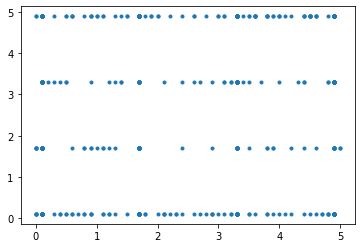

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure()
plt.plot(x_labs_task, pred_labs1, '.')
plt.figure()
plt.plot(x_labs_task, pred_labs2, '.')

plt.figure()
plt.plot(pred_labs1, pred_labs2, '.')


In [33]:
np.mean(pred_labs1==x_labs_task)

0.2222222222222222

In [34]:
np.mean(pred_labs2==x_labs_task)

0.2152777777777778

In [8]:
np.mean(pred_labs1[is_main_grid_task]==x_labs_task[is_main_grid_task])

0.3203125

In [36]:
np.mean(pred_labs2[is_main_grid_task]==x_labs_task[is_main_grid_task])

0.3098958333333333

In [9]:
np.mean(pred_labs1[~is_main_grid_task]==x_labs_task[~is_main_grid_task])

0.026041666666666668

In [11]:
pred_labs1[~is_main_grid_task], x_labs_task[~is_main_grid_task]

(array([0.1, 1.7, 4.9, 4.9, 4.9, 4.9, 4.9, 1.7, 3.3, 3.3, 0.1, 0.1, 3.3,
        4.9, 3.3, 4.9, 3.3, 3.3, 4.9, 0.1, 0.1, 3.3, 3.3, 0.1, 3.3, 4.9,
        0.1, 0.1, 4.9, 4.9, 0.1, 4.9, 4.9, 1.7, 1.7, 4.9, 3.3, 4.9, 1.7,
        0.1, 4.9, 4.9, 0.1, 3.3, 0.1, 4.9, 4.9, 4.9, 0.1, 4.9, 3.3, 0.1,
        3.3, 0.1, 0.1, 4.9, 1.7, 3.3, 1.7, 0.1, 1.7, 4.9, 4.9, 4.9, 1.7,
        0.1, 1.7, 4.9, 0.1, 4.9, 1.7, 0.1, 0.1, 0.1, 0.1, 1.7, 4.9, 0.1,
        4.9, 4.9, 0.1, 0.1, 0.1, 4.9, 4.9, 0.1, 4.9, 4.9, 0.1, 4.9, 0.1,
        1.7, 1.7, 0.1, 4.9, 0.1, 3.3, 4.9, 0.1, 0.1, 4.9, 3.3, 4.9, 0.1,
        3.3, 4.9, 0.1, 4.9, 4.9, 1.7, 4.9, 3.3, 0.1, 4.9, 4.9, 0.1, 3.3,
        0.1, 0.1, 4.9, 0.1, 4.9, 1.7, 0.1, 3.3, 3.3, 4.9, 0.1, 4.9, 0.1,
        1.7, 4.9, 4.9, 1.7, 0.1, 0.1, 1.7, 0.1, 4.9, 4.9, 0.1, 0.1, 0.1,
        0.1, 1.7, 4.9, 0.1, 1.7, 0.1, 4.9, 3.3, 4.9, 0.1, 0.1, 4.9, 4.9,
        3.3, 1.7, 4.9, 3.3, 1.7, 4.9, 1.7, 3.3, 1.7, 0.1, 0.1, 0.1, 4.9,
        0.1, 1.7, 1.7, 4.9, 0.1, 3.3, 0.1, 3.3, 4.9

In [12]:
x_labs_task[~is_main_grid_task]

array([0.8, 0.1, 0.5, 2. , 1.1, 0.9, 4.5, 2.4, 2.7, 4.8, 0. , 3.1, 4.3,
       2.6, 3.4, 3.6, 3.5, 4.8, 3.8, 0.8, 2.8, 3.2, 0.3, 1.7, 0.5, 0.6,
       1.8, 3.2, 4.8, 2.2, 3.3, 1. , 1.8, 0. , 0. , 0.9, 1.4, 1.5, 3.5,
       2.3, 0.6, 3.1, 4.6, 3.7, 4.7, 3.6, 3.6, 4.6, 0.9, 3.4, 2.6, 1.1,
       4.4, 3.9, 2.9, 4.1, 3.8, 2.4, 1.1, 1.8, 0.8, 0. , 0.8, 2.8, 1.3,
       3.2, 1. , 3.9, 3.5, 1.1, 1.2, 4.2, 4.8, 0.5, 2.3, 0. , 4.4, 0.6,
       4.5, 3.6, 1.2, 4.8, 0.6, 4.4, 0. , 2.7, 1.9, 4.5, 2.1, 4.6, 3.8,
       3.8, 5. , 0. , 2. , 2.2, 2.9, 1.3, 1.5, 2.1, 3.8, 3.1, 1.5, 0.1,
       1.3, 3.8, 4.4, 1.4, 4. , 0.8, 4.5, 3.2, 0.1, 4.6, 4. , 0.4, 3.3,
       2.9, 1.3, 3.1, 0.4, 4.5, 4.4, 0.9, 2.1, 0.5, 4.5, 0.7, 0.5, 0. ,
       1.7, 4. , 1.7, 0.6, 4. , 4.1, 3.9, 2.4, 3.5, 0.6, 3.6, 0.9, 2.9,
       3.8, 1.1, 0.1, 1.2, 4.6, 4.7, 4.2, 0.4, 0.9, 4.9, 2. , 3.6, 3. ,
       0.2, 3.9, 3.8, 1.2, 2.9, 3.5, 0.9, 4. , 0.9, 1.1, 2.1, 0.1, 4.4,
       1.7, 0. , 5. , 2.6, 4.5, 4.4, 0.3, 1.4, 2.4, 2.6, 4.2, 1.

In [21]:
preds_all = dict()
probs_all = dict()

In [24]:
preds_all[ss] = prob_each1

In [19]:
np.argmax(prob_each1[~is_main_grid_task,:], axis=1)

array([0, 1, 3, 3, 3, 3, 3, 1, 2, 2, 0, 0, 2, 3, 2, 3, 2, 2, 3, 0, 0, 2,
       2, 0, 2, 3, 0, 0, 3, 3, 0, 3, 3, 1, 1, 3, 2, 3, 1, 0, 3, 3, 0, 2,
       0, 3, 3, 3, 0, 3, 2, 0, 2, 0, 0, 3, 1, 2, 1, 0, 1, 3, 3, 3, 1, 0,
       1, 3, 0, 3, 1, 0, 0, 0, 0, 1, 3, 0, 3, 3, 0, 0, 0, 3, 3, 0, 3, 3,
       0, 3, 0, 1, 1, 0, 3, 0, 2, 3, 0, 0, 3, 2, 3, 0, 2, 3, 0, 3, 3, 1,
       3, 2, 0, 3, 3, 0, 2, 0, 0, 3, 0, 3, 1, 0, 2, 2, 3, 0, 3, 0, 1, 3,
       3, 1, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 1, 0, 3, 2, 3, 0, 0,
       3, 3, 2, 1, 3, 2, 1, 3, 1, 2, 1, 0, 0, 0, 3, 0, 1, 1, 3, 0, 2, 0,
       2, 3, 0, 1, 3, 0, 2, 3, 3, 0, 0, 3, 0, 3, 2, 0])

In [178]:
# hold the predicted labels for entire dataset
pred_labs2 = np.full(fill_value=np.nan, shape=(np.shape(cv_labs_task)))
# x_labs_task_adj = 
for cvi, cv in enumerate(np.unique(cv_labs_task)):

    print(cvi)
    # holding out one run at a time as a test set
    # training set is all the other runs, only main grid trials.
    trninds = (cv_labs_task!=cv) & (is_main_grid_task)
    tstinds = cv_labs_task==cv

    trndat = dat[trninds,:]
    tstdat = dat[tstinds,:]

    trnlabs = (x_labs_task[trninds]*10).astype(int)
    assert(len(np.unique(trnlabs))==4)

    # nest_cv_labs = cv_labs_task[trninds]
    
    C = 0.1;
    model_pars = [C, n_threads]

    model = get_model(*model_pars)

    m = ordinal.OrdinalClassifier(model)

    m.fit(trndat, trnlabs)
    p = m.predict(tstdat)

    pred_labs2[tstinds] = p/10
    

0
1
2
3
4
5
6
7
8
9
10
11


In [173]:
np.mean(pred_labs2==x_labs_task)

0.2708333333333333

In [174]:
pred_labs1

array([4.9, 1.7, 0.1, 1.7, 4.9, 3.3, 0.1, 3.3, 3.3, 1.7, 4.9, 1.7, 0.1,
       0.1, 4.9, 3.3, 3.3, 1.7, 3.3, 1.7, 1.7, 4.9, 3.3, 3.3, 0.1, 3.3,
       4.9, 1.7, 0.1, 1.7, 4.9, 0.1, 0.1, 4.9, 4.9, 0.1, 4.9, 3.3, 1.7,
       3.3, 3.3, 0.1, 1.7, 3.3, 1.7, 0.1, 3.3, 1.7, 4.9, 1.7, 1.7, 1.7,
       4.9, 3.3, 1.7, 4.9, 3.3, 4.9, 1.7, 1.7, 3.3, 1.7, 0.1, 1.7, 1.7,
       3.3, 1.7, 4.9, 3.3, 3.3, 4.9, 4.9, 4.9, 3.3, 1.7, 0.1, 0.1, 3.3,
       1.7, 3.3, 4.9, 4.9, 1.7, 3.3, 4.9, 3.3, 4.9, 4.9, 1.7, 3.3, 0.1,
       4.9, 1.7, 1.7, 0.1, 3.3, 3.3, 3.3, 0.1, 3.3, 3.3, 0.1, 3.3, 1.7,
       4.9, 4.9, 3.3, 4.9, 0.1, 3.3, 0.1, 1.7, 4.9, 1.7, 4.9, 3.3, 4.9,
       3.3, 1.7, 1.7, 4.9, 4.9, 3.3, 0.1, 1.7, 1.7, 3.3, 3.3, 3.3, 1.7,
       3.3, 4.9, 3.3, 4.9, 4.9, 4.9, 0.1, 3.3, 3.3, 3.3, 3.3, 1.7, 3.3,
       0.1, 3.3, 3.3, 1.7, 1.7, 1.7, 1.7, 0.1, 1.7, 4.9, 4.9, 0.1, 3.3,
       4.9, 3.3, 0.1, 0.1, 1.7, 3.3, 1.7, 1.7, 1.7, 1.7, 3.3, 3.3, 0.1,
       3.3, 4.9, 3.3, 4.9, 4.9, 1.7, 0.1, 4.9, 3.3, 4.9, 3.3, 0.

In [2]:
from code_utils.OrdinalClassifier import ordinal

In [43]:
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')

In [51]:
model = sklearn.linear_model.LogisticRegressionCV(Cs = c_values, \
                                                  solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')

In [27]:
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', \
                                                    penalty=None,
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')

In [35]:
model = sklearn.svm.SVC(probability=True)

In [52]:
# model = get_model(fake_cv_labs, c_values, n_threads)
o = ordinal.OrdinalClassifier(model)

In [53]:
o.fit(fake_trndata, fake_trnlabels)

OrdinalClassifier(estimator=LogisticRegressionCV(Cs=array([1.00000000e-09, 3.35981829e-09, 1.12883789e-08, 3.79269019e-08,
       1.27427499e-07, 4.28133240e-07, 1.43844989e-06, 4.83293024e-06,
       1.62377674e-05, 5.45559478e-05, 1.83298071e-04, 6.15848211e-04,
       2.06913808e-03, 6.95192796e-03, 2.33572147e-02, 7.84759970e-02,
       2.63665090e-01, 8.85866790e-01, 2.97635144e+00, 1.00000000e+01]),
                                                 class_weight='balanced',
                                                 max_iter=1000, n_jobs=8))

In [54]:
pred_labs = o.predict(fake_tstdata)
np.mean(pred_labs==fake_tstlabels)

0.5

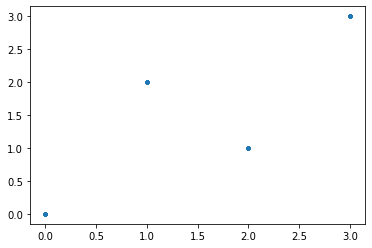

In [55]:
plt.figure()
plt.plot(fake_tstlabels, pred_labs, '.')

In [132]:
fake_trnlabels = np.repeat(np.arange(19), 100)
fake_tstlabels = np.repeat(np.arange(19), 50)
# fake_trnlabels = np.repeat(np.arange(4), 100)
# fake_tstlabels = np.repeat(np.arange(4), 50)

fake_cv_labs = np.tile(np.arange(10), [190,])
# fake_cv_labs = np.tile(np.arange(10), [40,])
w = np.abs(np.random.normal(0,1,[1,200]))

fake_trndata = fake_trnlabels[:,None] @ w
fake_trndata += np.random.normal(0, 1, fake_trndata.shape)*5
fake_tstdata = fake_tstlabels[:,None] @ w
fake_tstdata += np.random.normal(0, 1, fake_tstdata.shape)*5


In [133]:
# model_pars = [fake_cv_labs, c_values, n_threads]
# C = 1.0
C = 0.01;
model_pars = [C, n_threads]

m = ordinal_regress_model(get_model)
m.fit(fake_trndata, fake_trnlabels, model_pars)
pred_labs1 = m.predict(fake_tstdata)

np.mean(pred_labs1==fake_tstlabels)

0.6978947368421052

In [137]:
# c_values = np.logspace(-9, 1, 20)
c_values = np.array([0.01, 0.0001])
n_threads = 8;

model_pars = [fake_cv_labs, c_values, n_threads]
# C = 1.0
# C = 0.000001;
# model_pars = [C, n_threads]

m = ordinal_regress_model(get_model_cv)
m.fit(fake_trndata, fake_trnlabels, model_pars)
pred_labs2 = m.predict(fake_tstdata)

np.mean(pred_labs2==fake_tstlabels)

0.6547368421052632

In [139]:
# model_pars = [fake_cv_labs, c_values, n_threads]
# C = 1.0
# C = 0.000001;
C = 0.01;
model_pars = [C, n_threads]
model = get_model(*model_pars)

m = ordinal.OrdinalClassifier(model)
m.fit(fake_trndata, fake_trnlabels)
pred_labs3 = m.predict(fake_tstdata)

np.mean(pred_labs3==fake_tstlabels)

0.6978947368421052

In [146]:
m.estimators_[0].classes

AttributeError: 'LogisticRegression' object has no attribute 'classes'

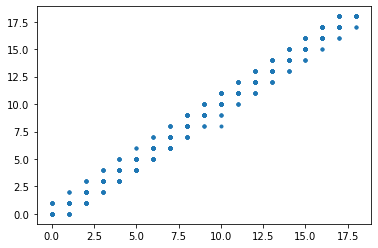

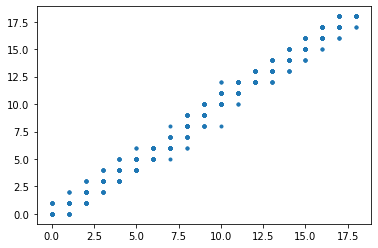

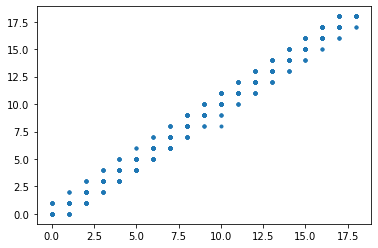

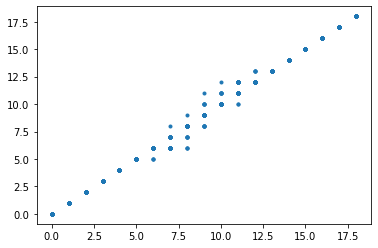

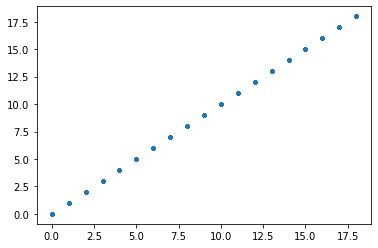

In [138]:
plt.figure()
plt.plot(fake_tstlabels, pred_labs1, '.')
plt.figure()
plt.plot(fake_tstlabels, pred_labs2, '.')
plt.figure()
plt.plot(fake_tstlabels, pred_labs3, '.')
plt.figure()
plt.plot(pred_labs1, pred_labs2, '.')
plt.figure()
plt.plot(pred_labs1, pred_labs3, '.')


In [124]:
# model = clf_func(*model_pars)
def get_model_cv(nest_cv_labs, c_values, n_threads):

    # to get regularization params, will cross-validate within the training set
    # make a custom cv generator that leaves one run out at a time
    nest_cv_obj = sklearn.model_selection.LeaveOneGroupOut()
    nest_cv_generator = nest_cv_obj.split(np.zeros((len(nest_cv_labs),1)), \
                                          np.zeros((len(nest_cv_labs),)), nest_cv_labs)
    
    # define model
    st = time.time()
    model = sklearn.linear_model.LogisticRegressionCV(cv = nest_cv_generator, \
                                                    Cs = c_values, \
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')
    return model

In [117]:
# model = clf_func(*model_pars)
# c_values = np.logspace(-9, 1, 20)
n_threads = 8;
# 
def get_model(C, n_threads):
    
    model = sklearn.linear_model.LogisticRegression(C = C, \
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')
    return model

In [123]:
class ordinal_regress_model():
    
    def __init__(self, clf_func):
        
        # clf_func is a function that will generate a classifier object
        # (in this case sklearn.linear_model.LogisticRegressionCV)
        # can pass more arguments in during fitting (model_pars)
        self.clf_func = clf_func
        
    def fit(self, X, y, model_pars=[]):
        
        # y values will be sorted lowest to highest
        self.unique_y = np.unique(y)
        self.n_y = len(self.unique_y)
        self.n_clf = self.n_y - 1

        # make sets of binary labels for our different classifiers
        ylabs_binary = [(y > y0).astype(int) for y0 in self.unique_y[0:-1]]
        
        self.models_fitted = []

        for yi in range(self.n_clf):

            # create the classifier object (can pass in arguments here)
            model = self.clf_func(*model_pars)

            model.fit(X, ylabs_binary[yi])

            self.models_fitted += [model]
            

    def predict(self, X):

        # compute prediction for each individual classifier
        # these values will represent probability of >value
        preds_binary = np.array([self.models_fitted[yi].predict_proba(X)[:,1] \
                                 for yi in range(self.n_clf)]).T
        # prob_each = np.array([1-preds_binary[:,0], \
        #                             np.diff(preds_binary, axis=1), \
        #                             preds_binary[:,-1]]).T

        # now convert these back into probabilities for individual classes
        prob_each = np.zeros((X.shape[0], self.n_y), dtype=np.float64)
        for yi in range(self.n_y):
            if yi==0:
                # smallest value, classifier is >this value, so take 1-prob
                prob_each[:,yi] = 1-preds_binary[:,0]
            elif yi==(self.n_y-1):
                # biggest value, classifier is >previous value
                prob_each[:,yi] = preds_binary[:,yi-1]
            else:
                # middle value, classifier is >previous value - >this value
                prob_each[:,yi] = preds_binary[:,yi-1] - preds_binary[:,yi] 

        # prob of all classes should sum up to 1
        assert(np.all(np.sum(prob_each, axis=1).round(9)==1))

        # get max prob as predicted label
        lab_ind = np.argmax(prob_each, axis=1)
        lab = self.unique_y[lab_ind]
        
        return lab


In [5]:
ordinal.

<module 'code_utils.OrdinalClassifier.ordinal' from '/usr/local/serenceslab/maggie/shapeDim/Analysis/code_utils/OrdinalClassifier/ordinal.py'>

In [176]:
# c_values = np.logspace(-9, 1, 20)
c_values = np.array([0.01, 0.0001])
n_threads = 8;

model_pars = [fake_cv_labs, c_values, n_threads]
# C = 1.0
# C = 0.000001;
# model_pars = [C, n_threads]

m = ordinal_regress_model(get_model_cv)
m.fit(fake_trndata, fake_trnlabels, model_pars)
pred_labs2 = m.predict(fake_tstdata)

np.mean(pred_labs2==fake_tstlabels)

0.6547368421052632

In [139]:
# model_pars = [fake_cv_labs, c_values, n_threads]
# C = 1.0
# C = 0.000001;
C = 0.01;
model_pars = [C, n_threads]
model = get_model(*model_pars)

m = ordinal.OrdinalClassifier(model)
m.fit(fake_trndata, fake_trnlabels)
pred_labs3 = m.predict(fake_tstdata)

np.mean(pred_labs3==fake_tstlabels)

0.6978947368421052

In [27]:
np.mean(x_labs_task==pred_labs)

0.265625

In [29]:
np.unique(x_labs_task).shape

(12,)

In [30]:
1/12

0.08333333333333333

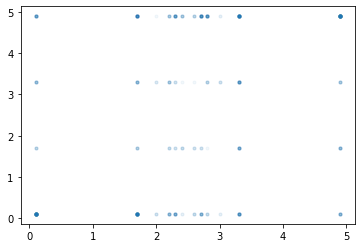

In [38]:
plt.figure()
plt.plot(x_labs_task, pred_labs, '.', alpha=0.05)

In [24]:
# model = clf_func(*model_pars)
c_values = np.logspace(-9, 1, 20)
n_threads = 8;

def get_model(nest_cv_labs, c_values, n_threads):

    # to get regularization params, will cross-validate within the training set
    # make a custom cv generator that leaves one run out at a time
    nest_cv_obj = sklearn.model_selection.LeaveOneGroupOut()
    nest_cv_generator = nest_cv_obj.split(np.zeros((len(nest_cv_labs),1)), \
                                          np.zeros((len(nest_cv_labs),)), nest_cv_labs)
    
    # define model
    st = time.time()
    model = sklearn.linear_model.LogisticRegressionCV(cv = nest_cv_generator, \
                                                    Cs = c_values, \
                                                    solver='lbfgs', \
                                                    penalty='l2', \
                                                    n_jobs = n_threads , \
                                                    max_iter = 1000, 
                                                    class_weight = 'balanced')
    return model

In [1]:
from code_utils.OrdinalClassifier import ordinal
# from code_utils.OrdinalClassifer import ordinal

ModuleNotFoundError: No module named 'code_utils'

In [39]:
# fake_trnlabels = np.repeat(np.arange(19), 100)
# fake_tstlabels = np.repeat(np.arange(19), 50)
fake_trnlabels = np.repeat(np.arange(4), 100)
fake_tstlabels = np.repeat(np.arange(4), 50)

fake_cv_labs = np.tile(np.arange(10), [40,])
w = np.abs(np.random.normal(0,1,[1,200]))

fake_trndata = fake_trnlabels[:,None] @ w
fake_trndata += np.random.normal(0, 1, fake_trndata.shape)
fake_tstdata = fake_tstlabels[:,None] @ w
fake_tstdata += np.random.normal(0, 1, fake_tstdata.shape)

In [40]:
model_pars = [fake_cv_labs, c_values, n_threads]
m = ordinal_regress_model(get_model)
m.fit(fake_trndata, fake_trnlabels, model_pars)

In [41]:
# best_cvals = [m.models_fitted[ii].C_[0] for ii in range(3)]

preds_binary = np.array([m.models_fitted[yi].predict_proba(fake_tstdata)[:,1] \
                         for yi in range(m.n_clf)]).T

# convert to probability each class
prob_each = np.concatenate([1-preds_binary[:,0:1], \
                            (-1)*np.diff(preds_binary, axis=1), \
                            preds_binary[:,-1:]], axis=1)

In [42]:
pred = np.argmax(prob_each, axis=1)

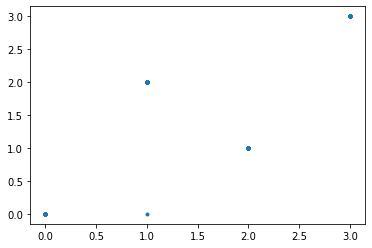

In [43]:
plt.figure()
plt.plot(fake_tstlabels, pred,'.')

In [45]:
ind = np.where(fake_tstlabels==1)[0][0]
prob_each[ind,:].round(3)

array([0.353, 0.148, 0.475, 0.025])

In [48]:
preds_binary[ind,:].round(3)

array([0.647, 0.5  , 0.025])

In [47]:
(-1)*np.diff(preds_binary[ind,:]).round(3)

array([0.148, 0.475])

In [ ]:
# pred = m.predict(fake_tstdata)
pred = m.predict(fake_tstdata)

In [265]:
# compute prediction for each individual classifier
# these values will represent probability of >value


In [264]:
fake_tstdata.shape

(950, 200)

In [311]:
inds = np.where(fake_trnlabels==5)[0][0]

prob_each[inds].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.066, 0.168, 0.26 ,
       0.   , 0.016, 0.193, 0.227, 0.063, 0.002, 0.   , 0.   , 0.   ,
       0.   ])

In [312]:
np.argmax(prob_each[inds])

8

In [266]:
preds_binary = [m.models_fitted[yi].predict_proba(fake_tstdata)[:,1] \
                         for yi in range(m.n_clf)]
# now convert these back into probabilities for individual classes
prob_each = np.zeros((fake_tstdata.shape[0], m.n_y), dtype=np.float64)
for yi in range(m.n_y):
    if yi==0:
        # smallest value, classifier is >this value, so take 1-prob
        prob_each[:,yi] = 1-preds_binary[0]
    elif yi==(m.n_y-1):
        # biggest value, classifier is >previous value
        prob_each[:,yi] = preds_binary[yi-1]
    else:
        # middle value, classifier is >previous value - >this value
        prob_each[:,yi] = preds_binary[yi-1] - preds_binary[yi] 

In [274]:
# preds_binary.shape
np.diff(preds_binary, axis=1).shape

(950, 17)

In [281]:
prob_each2.shape

(950, 18)

In [299]:
preds_binary[0,:]

array([1.36258372e-02, 1.76798663e-03, 1.17655215e-04, 3.60289199e-04,
       6.99057589e-05, 5.24010205e-04, 3.01334347e-03, 1.33605791e-02,
       4.98127358e-01, 4.98020247e-01, 3.99407191e-03, 9.61010927e-05,
       1.93181633e-07, 4.96474060e-12, 4.53079379e-13, 5.67202217e-22,
       2.32352073e-24, 8.75946254e-42])

In [301]:
preds_binary[0,1] - preds_binary[0,0]

-0.011857850528329711

In [300]:
np.diff(preds_binary[0,:])

array([-1.18578505e-02, -1.65033142e-03,  2.42633985e-04, -2.90383440e-04,
        4.54104446e-04,  2.48933327e-03,  1.03472356e-02,  4.84766779e-01,
       -1.07111246e-04, -4.94026175e-01, -3.89797081e-03, -9.59079111e-05,
       -1.93176668e-07, -4.51166122e-12, -4.53079378e-13, -5.64878696e-22,
       -2.32352073e-24])

In [303]:
prob_each[100,:]

array([ 1.24632966e-03,  3.98909451e-01,  5.31780667e-01,  4.81221006e-02,
        1.63248972e-02, -3.07924600e-03, -9.10972720e-03, -2.29027041e-02,
       -4.59893623e-01,  1.07148591e-04,  4.86710721e-01,  1.12735958e-02,
        5.07905413e-04,  2.48290088e-06,  2.32200047e-10,  2.55754504e-11,
        3.50814728e-19,  1.96909611e-21,  5.06898280e-37])

In [304]:
prob_each[100,:]

array([ 1.24632966e-03,  3.98909451e-01,  5.31780667e-01,  4.81221006e-02,
        1.63248972e-02, -3.07924600e-03, -9.10972720e-03, -2.29027041e-02,
       -4.59893623e-01,  1.07148591e-04,  4.86710721e-01,  1.12735958e-02,
        5.07905413e-04,  2.48290088e-06,  2.32200047e-10,  2.55754504e-11,
        3.50814728e-19,  1.96909611e-21,  5.06898280e-37])

In [306]:
np.all(prob_each==prob_each2)

True

In [243]:
fake_trnlabels = np.repeat(np.arange(19), 100)
fake_tstlabels = np.repeat(np.arange(19), 50)

fake_cv_labs = np.tile(np.arange(10), [190,])
w = np.abs(np.random.normal(0,1,[1,200]))

fake_trndata = fake_trnlabels[:,None] @ w
fake_trndata += np.random.normal(0, 0.1, fake_trndata.shape)
fake_tstdata = fake_tstlabels[:,None] @ w
fake_tstdata += np.random.normal(0, 0.1, fake_tstdata.shape)

In [244]:
model_pars = [fake_cv_labs, c_values, n_threads]
m = ordinal_regress_model(get_model)
m.fit(fake_trndata, fake_trnlabels, model_pars)

best_cvals = [m.models_fitted[ii].C_[0] for ii in range(3)]

In [245]:
# pred = m.predict(fake_tstdata)
pred = m.predict(fake_tstdata)

In [246]:
np.mean(pred==fake_tstlabels)

0.42105263157894735

In [237]:
1/19

0.05263157894736842

In [252]:
inds = np.where(fake_trnlabels==5)[0][0]

y = fake_trnlabels
ylabs_binary = [(y > y0).astype(int) for y0 in m.unique_y[0:-1]]

for yi in [0,1,2,3,4,5,6,7]:

    model = m.clf_func(*model_pars)
    
    # d, l = resamp_up(fake_trndata, ylabs_binary[yi])
    d, l = fake_trndata, ylabs_binary[yi]
    model.fit(d,l)
    
    print(d.shape)
    print(np.mean(l))
    
    # print(fake_trnlabels[inds])
    print(yi, model.predict_proba(fake_trndata)[inds])
    # print(yi, model.predict_log_proba(fake_trndata)[inds].round(2))

(1900, 200)
0.9473684210526315
0 [8.75224337e-11 1.00000000e+00]
(1900, 200)
0.8947368421052632
1 [2.67629245e-05 9.99973237e-01]
(1900, 200)
0.8421052631578947
2 [8.74410227e-04 9.99125590e-01]
(1900, 200)
0.7894736842105263
3 [0.10314305 0.89685695]
(1900, 200)
0.7368421052631579
4 [0.42225287 0.57774713]
(1900, 200)
0.6842105263157895
5 [0.76203958 0.23796042]
(1900, 200)
0.631578947368421
6 [0.83520112 0.16479888]
(1900, 200)
0.5789473684210527
7 [0.8285708 0.1714292]


In [212]:
# compute prediction for each individual classifier
# these values will represent probability of >value
preds_binary = [m.models_fitted[yi].predict_log_proba(fake_trndata)[:,1] for yi in range(m.n_clf)]

# now convert these back into probabilities for individual classes
prob_each = np.zeros((fake_trndata.shape[0], m.n_y), dtype=np.float64)
for yi in range(m.n_y):
    if yi==0:
        # smallest value, classifier is >this value, so take 1-prob
        prob_each[:,yi] = 1-preds_binary[0]
    elif yi==(m.n_y-1):
        # biggest value, classifier is >previous value
        prob_each[:,yi] = preds_binary[yi-1]
    else:
        # middle value, classifier is >previous value - >this value
        prob_each[:,yi] = preds_binary[yi-1] - preds_binary[yi] 

# prob of all classes should sum up to 1
assert(np.all(np.sum(prob_each, axis=1).round(9)==1))

# get max prob as predicted label
lab_ind = np.argmax(prob_each, axis=1)
lab = m.unique_y[lab_ind]


In [142]:
inds = np.where(fake_trnlabels==2)[0][0]

In [201]:
def resamp_up(dat, labs):
    
    unlabs, counts = np.unique(labs, return_counts=True)
    n_max = np.max(counts)
    
    newdat = []
    newlabs = []
    for uu in unlabs:
        inds = labs==uu
        n = np.sum(inds)
        d = dat[inds]
        l = labs[inds]
        if n < n_max:
            n_add = n_max - n
            inds_add = np.random.choice(np.arange(n), n_add, replace=True)
            d_add = d[inds_add,:]
            # d_add += np.random.normal(0,0.1,d_add.shape)
            d = np.concatenate([d, d_add], axis=0)
            l = np.concatenate([l, l[inds_add]], axis=0)
        newdat += [d]
        newlabs += [l]
        
    newdat = np.concatenate(newdat, axis=0)
    newlabs = np.concatenate(newlabs, axis=0)
            
    return newdat, newlabs

In [191]:
yi = 0;
d, l = resamp_up(fake_trndata, ylabs_binary[yi])
d.shape

(1600, 20)

In [193]:
np.mean(l)

0.5

In [187]:
dat = fake_trndata
labs = ylabs_binary[yi]
unlabs = np.unique(labs)
n_max = np.min(unlabs)
unlabs, n_max    

(array([0, 1]), 0)

In [185]:
ylabs_binary[yi]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [207]:
y = fake_trnlabels
ylabs_binary = [(y > y0).astype(int) for y0 in m.unique_y[0:-1]]

for yi in [0,1,2,3,4,5,6,7]:

    
    model = m.clf_func(*model_pars)
    
    # d, l = resamp_up(fake_trndata, ylabs_binary[yi])
    d, l = fake_trndata, ylabs_binary[yi]
    model.fit(d,l)
    
    print(d.shape)
    print(np.mean(l))
    
    # print(fake_trnlabels[inds])
    print(yi, model.predict_proba(fake_trndata)[inds])
    print(yi, model.predict_log_proba(fake_trndata)[inds].round(2))

(900, 20)
0.8888888888888888
0 [0.01120516 0.98879484]
0 [-4.49 -0.01]
(900, 20)
0.7777777777777778
1 [0.42057842 0.57942158]
1 [-0.87 -0.55]
(900, 20)
0.6666666666666666
2 [0.76784888 0.23215112]
2 [-0.26 -1.46]
(900, 20)
0.5555555555555556
3 [0.50156727 0.49843273]
3 [-0.69 -0.7 ]
(900, 20)
0.4444444444444444
4 [0.50201193 0.49798807]
4 [-0.69 -0.7 ]
(900, 20)
0.3333333333333333
5 [0.99007671 0.00992329]
5 [-0.01 -4.61]
(900, 20)
0.2222222222222222
6 [9.99928204e-01 7.17955430e-05]
6 [-0.   -9.54]
(900, 20)
0.1111111111111111
7 [9.99999998e-01 2.47540181e-09]
7 [ -0.   -19.82]


In [212]:
# compute prediction for each individual classifier
# these values will represent probability of >value
preds_binary = [m.models_fitted[yi].predict_log_proba(fake_trndata)[:,1] for yi in range(m.n_clf)]

# now convert these back into probabilities for individual classes
prob_each = np.zeros((fake_trndata.shape[0], m.n_y), dtype=np.float64)
for yi in range(m.n_y):
    if yi==0:
        # smallest value, classifier is >this value, so take 1-prob
        prob_each[:,yi] = 1-preds_binary[0]
    elif yi==(m.n_y-1):
        # biggest value, classifier is >previous value
        prob_each[:,yi] = preds_binary[yi-1]
    else:
        # middle value, classifier is >previous value - >this value
        prob_each[:,yi] = preds_binary[yi-1] - preds_binary[yi] 

# prob of all classes should sum up to 1
assert(np.all(np.sum(prob_each, axis=1).round(9)==1))

# get max prob as predicted label
lab_ind = np.argmax(prob_each, axis=1)
lab = m.unique_y[lab_ind]


In [217]:
np.argmax(np.diff([preds_binary[ii][inds] for ii in range(m.n_clf)]))

2

In [213]:
lab

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [208]:
0.9888 - 0.5974, 0.5974 - 0.232

(0.39139999999999997, 0.36540000000000006)

In [150]:
yi = 0;
model = m.clf_func(*model_pars)
model.fit(fake_trndata, ylabs_binary[yi])
p = model.predict(np.random.normal(0,1,np.shape(fake_trndata)))  
p.shape

(900,)